# Исследование рынка Гейминга

**Цель исследования**

Выявить закономерности, определяющие успешность игры, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в интернет-магазине «Стримчик» на следующий отчетный год.

**Описание данных**

Данные по 2016 год, собраны из открытых источников.

- название игры
- платформа
- год выпуска
- жанр игры
- продажи (миллионы проданных копий)
- оценка критиков (максимум 100)
- оценка пользователей (максимум 10)
- рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

*Данные за 2016 год могут быть неполными*.

**Ход исследования**

1. Проведем обзор данных - составим первое представление о предоставленных данных, оценим их объем и качество.
2. Выполним подготовку данных к анализу - проверим данные на возможные ошибки (аномалии, пропуски). Исправим данные.
3. Исследуем данные.
4. Составим  портреты геймеров по регионам.
5. Проверим гипотезы.
6. Подведем итоги исследования.

## 1. Обзор данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

Загрузим данные, сохраним их в переменной *df*, выведем 5 верхних строк

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


По выведенным строкам датафрейма видим в нескольких столбцах наличие пропусков - NaN, некорректный формат отображения года в столбце *Year_of_Release*.
Посмотрим на типы данных в столбцах и их объем.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датафрейм состоит из 11 столбцов и 16715 строк. В части столбцов количество строк отличается от 16715, в этих столбцах есть пропуски данных. Названия столбцов далее приведем к нижнему регистру.  

Типы данных float64 и object. Потребуется корректировка типов данных в столбцах:
- *Year_of_Release*, т.к. у года не может быть тип данных float; 
- *User_Score*, т.к. этот столбец содержит оценку пользователей, это число, а у нас тип данных object.

Объем памяти примерно 1,4MB.

**Выводы**

- В датафрейме 11 столбцов и 16715 строк;
- Типы данных float64 и object. В 2-х столбцах: *Year_of_Release* и *User_Score* проведем корректировку типов данных на 'int' и 'float' , соответственно.;
- Названия столбцов не соответствуют стилю, их приведем к нижнему регистру;
- В 6 столбцах содержатся пропуски данных. Значительное количество данных пропущено в столбцах *Critic_Score*, *User_Score*, *Rating*. Поскольку данные собирались из открытых источников, часть данных могла там отсутствовать, могли произойти ошибки при загрузке. Возможно у каких-то игр отсутствуют оценки критиков или пользователей (в выгрузке встречаются игры , выпущенные в 80-х, 90-х годах 20в)

Исправлением несоответствий в данных займемся на следующем этапе.

## 2. Подготовка (предобработка) данных

Первым шагом приведем названия столбцов к нижнему регистру.

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.1. Проверка на аномалии и замена пропусков

В ряде столбцов у нас отсутствуют значения, оценим объемы пропусков.

In [5]:
(df.isna().mean()*100).sort_values(ascending=False)

critic_score       51.319174
rating             40.478612
user_score         40.089740
year_of_release     1.609333
name                0.011965
genre               0.011965
platform            0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
dtype: float64

Пропуски данных есть в 6 столбцах, в т.ч. в тех, у которых нам нужно поменять тип данных *year_of_release, user_score*. В 3-х последних столбцах значительный % пропущенных значений > 40%. Сначала разберемся с пропусками, а затем заменим тип данных.

#### 2.1.1. Пропуски в столбце *name* мы заменить не сможем, т.к. пропущено название игры. 

Пропуски в данном случае обусловлены техническими причинами при сборе или выгрузке. Удалим из датафрейма строки с пропусками в этом столбце.

In [6]:
df = df.dropna(subset=['name']).reset_index(drop=True)
df.name.isna().sum()

0

Мы удалили строки с пропущенными названиями игр.

#### 2.1.2. Обратимся к столбцу *year_of_release*. 
Сначала посмотрим, какие годы представлены в датафрейме

In [7]:
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [8]:
df['year_of_release'].nunique()

37

В датафрейме данные с 1980 по 2016 годы, за 37 лет. Аномальные значения отсутствуют. 
Столбец с годом выпуска содержит 1,61% пропусков. Пустоты могут быть связаны с техническими причинами при сборе информации или при хранении данных. Выведем датафрейм с пропусками в годе и посмотрим детально по 2-3 играм наличие года выпуска.

In [9]:
print('В столбце "year_of_release" количество пропусков равно:', df.year_of_release.isna().sum())

В столбце "year_of_release" количество пропусков равно: 269


In [10]:
df[df['year_of_release'].isna()].head(7)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E


In [11]:
df.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1880,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3888,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5707,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [12]:
df.query('name == "Space Invaders"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
4263,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN
8579,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN
10382,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN


В игре *Madden NFL 2004* один год выпуска 2003.  А игра *Space Invaders* имела несколько релизов - 1994,1999,2002. Заменим пропуски годом последнего релиза.

In [13]:
for t in df['name'].unique():
    df.loc[(df['name'] == t) & (df['year_of_release'].isna()), 'year_of_release'] = \
    df.loc[(df['name'] == t), 'year_of_release'].max()

df.year_of_release.isna().sum()

146

У нас осталось еще 146 строк с незаполненным годом. Это менее 1% от общего объема данных. Удалим эти пропуски.

In [14]:
df = df.dropna(subset=['year_of_release']).reset_index(drop=True)
df.year_of_release.isna().sum()

0

От пропусков избавились, теперь поменяем тип данных в этом столбце на *int* и проверим новый тип данных:

In [15]:
df.year_of_release = df.year_of_release.astype('int')
df.year_of_release.dtypes

dtype('int64')

#### 2.1.3. Посмотрим на пропуски в столбце *genre*, выведем их количество.

In [16]:
df.genre.isna().sum()

0

Пропуски отсутствуют, значит, они содержались в тех строках, которые мы удалили - без названия игр. Все игровые жанры в данных заполнены. Посмотрим, какие игровые жанры представлены и сколько их.

In [17]:
print('Количество игровых жанров:', df['genre'].nunique())
df['genre'].unique()

Количество игровых жанров: 12


array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

представлено 12 игровых жанров, их названия указаны корректно, дубли отсутствуют.

#### 2.1.4. Обратимся к столбцу *critic_score*, в этом столбце 51,31% пропусков. Оценим их количество:

In [18]:
print('Количество пропусков в столбце "critic_score":', df.critic_score.isna().sum())

Количество пропусков в столбце "critic_score": 8492


Посмотрим на уникальные значения в этом столбце и их распределение.

In [19]:
df.critic_score.unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 13.])

Описание оценок критиков: 
 count    8075.000000
mean       68.991950
std        13.923383
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64


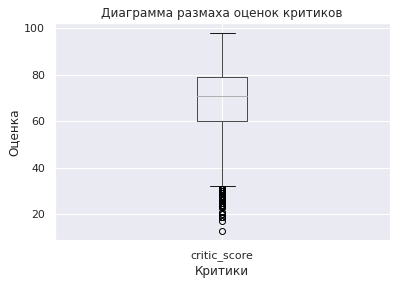

In [20]:
plt.title("Диаграмма размаха оценок критиков")
plt.xlabel("Критики")
plt.ylabel("Оценка")
df.boxplot('critic_score')
print('Описание оценок критиков: \n', df['critic_score'].describe())

Минимальная оценка критика равна 13, максимальная - 98, середина всех оценок - 71 балл. Есть незначительные выбросы в нижней части "ящика". Распределение со смещением вправо. Большинство оценок критиков находится в пределах межквартильного размаха 60-80 баллов. Аномальные и нетипичные значения отсутствуют. Пропуски в этом столбце оставим без изменений, т.к. любая замена приведет к последующим искажениям в результатах.

#### 2.1.5. Теперь перейдем к проверке данных в столбце *user_score*. 
В этом столбце примерно 40% пропусков. У части игр может отсутствовать оценка пользователей, у части игр оценка "потерялась " в процессе сбора/выгрузки информации - технический характер. Посчитаем количество пропусков и выведем уникальные значения в столбце:

In [21]:
print('Количество пропусков в столбце "user_score":', df.user_score.isna().sum())

Количество пропусков в столбце "user_score": 6633


Посмотрим на уникальные значения в этом столбце:

In [22]:
df.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пропусков, видим значение "tbd". Эта аббревиатура означает "To Be Determined", т.е. "Будет определено", значит, оценка отсутствует. Посчитаем количество этих значений.

In [23]:
len(df.query('user_score == "tbd"'))

2394

Значение "tbd" заменим на NaN - "оценка отсутствует".

In [24]:
df['user_score'] = df['user_score'].replace('tbd', np.nan, regex=True)

Теперь сможем изменить тип данных в столбце *user_score* на *float*.

In [25]:
df.user_score = df.user_score.astype('float')
df.user_score.dtypes

dtype('float64')

Сейчас у нас числовой тип столбца, можем построить график размаха.

Описание оценок пользователей: 
 count    7540.000000
mean        7.125027
std         1.498254
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64


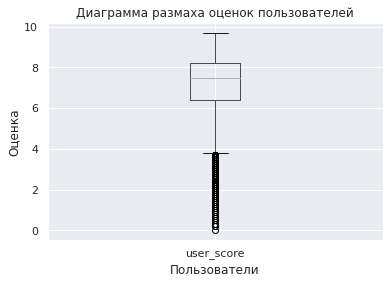

In [26]:
plt.title("Диаграмма размаха оценок пользователей")
plt.xlabel("Пользователи")
plt.ylabel("Оценка")
df.boxplot('user_score')
print('Описание оценок пользователей: \n', df['user_score'].describe())

Минимальная оценка от пользователей равна 0,0, максимальная - 9,7, середина всех оценок 7,5. Есть выбросы в нижней части графика. Распределение данных со смещением вправо. такое распределение говорит о том, что большинство оценок находится в пределах 6,3-8,1 баллов. (межквартильный размах). Но встречаются и низкие оценки пользователей - как раз выбросы.

#### 2.1.6. Остался последний столбец с пропусками - *rating*
Проверим его на уникальные значения и посчитаем количество пропусков. 

In [27]:
df['rating'].isna().sum()

6699

In [28]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Этот столбец содержит возрастные рейтинги согласно ассоциации ESRB www.esrb.org/ratings-guide/, https://dic.academic.ru/
которая определяет рейтинги ПО и игрового контента в США и Канаде.

Описание возрастных рейтингов:

- EC - "Early childhood". Игра подходит для детей от 3 лет;
- E10+ - "Everyone 10 and older". Возрастная категория — от 10 лет;
- E - "Everyone". Для возрастной категории от 6 лет и старше;
- T - "Teen". Игра подходит для лиц от 13 лет и старше;
- M - "Mature". Игры не подходят для подростков младше 17 лет;
- AO - "Adults Only 18+". Содержание игры только для взрослых;
- RP - "Рейтинг ожидается". Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официального релиза
- K-A - Kids to Adults, устаревший рейтинг.  «Для детей и взрослых». Подходит для возрастной категории от 6 лет и старше. Этот рейтинг был заменён на «Everyone» 1 января 1998 года и может встречаться только в играх, изданных ранее.

Рейтинги указаны корректно, без дубликатов.   
Рейтинг ESRB пропущен в 6764 строках. Пропуски возможны в случаях, если игра не представлялась к релизу в Северной Америке, либо не был указан в источнике, откуда собирали данные, либо имеет технические причины при сборе, хранении, выгрузке. Пропуски уместно заменить тем рейтингом, который есть у нас в таблице у конкретной игры. В случае отсутствия рейтинга у какой-то игры, пропуски сохранятся, заменим их на "indefined" - не определен.

Выведем 5 игр, которые в нашем файле представлены чаще всего и на примере одной из игр посмотрим, заполнение столбца *rating*:

In [29]:
df.name.value_counts().head()

Need for Speed: Most Wanted    12
LEGO Marvel Super Heroes        9
Ratatouille                     9
FIFA 14                         9
Madden NFL 07                   9
Name: name, dtype: int64

In [30]:
df.query('name == "LEGO Marvel Super Heroes"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
726,LEGO Marvel Super Heroes,X360,2013,Action,1.24,0.79,0.00,0.19,80.0,7.6,E10+
940,LEGO Marvel Super Heroes,PS3,2013,Action,0.77,0.76,0.01,0.29,82.0,7.9,E10+
1134,LEGO Marvel Super Heroes,PS4,2013,Action,0.59,0.76,0.01,0.26,83.0,7.7,E10+
1949,LEGO Marvel Super Heroes,XOne,2013,Action,0.61,0.35,0.00,0.09,NaN,6.8,E10+
2298,LEGO Marvel Super Heroes,3DS,2013,Action,0.42,0.36,0.04,0.07,61.0,5.2,E10+
2762,LEGO Marvel Super Heroes,WiiU,2013,Action,0.31,0.35,0.02,0.06,82.0,8.0,E10+
3856,LEGO Marvel Super Heroes,PSV,2013,Action,0.11,0.29,0.00,0.11,NaN,NaN,NaN
5019,LEGO Marvel Super Heroes,DS,2013,Action,0.22,0.13,0.00,0.03,NaN,4.8,E10+
8304,LEGO Marvel Super Heroes,PC,2013,Action,0.04,0.12,0.00,0.01,78.0,8.1,E10+


В игре *LEGO Marvel Super Heroes* из 9 строк рейтинг пропущен в 1-й. Заполним подобные пропуски аналогичным рейтингом.

In [31]:
for t in df['name'].unique():
    df.loc[(df['name'] == t) & (df['rating'].isna()), 'rating'] = \
    df.loc[(df['name'] == t), 'rating'].iloc[-1]

In [32]:
df.query('name == "LEGO Marvel Super Heroes"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
726,LEGO Marvel Super Heroes,X360,2013,Action,1.24,0.79,0.00,0.19,80.0,7.6,E10+
940,LEGO Marvel Super Heroes,PS3,2013,Action,0.77,0.76,0.01,0.29,82.0,7.9,E10+
1134,LEGO Marvel Super Heroes,PS4,2013,Action,0.59,0.76,0.01,0.26,83.0,7.7,E10+
1949,LEGO Marvel Super Heroes,XOne,2013,Action,0.61,0.35,0.00,0.09,NaN,6.8,E10+
2298,LEGO Marvel Super Heroes,3DS,2013,Action,0.42,0.36,0.04,0.07,61.0,5.2,E10+
2762,LEGO Marvel Super Heroes,WiiU,2013,Action,0.31,0.35,0.02,0.06,82.0,8.0,E10+
3856,LEGO Marvel Super Heroes,PSV,2013,Action,0.11,0.29,0.00,0.11,NaN,NaN,E10+
5019,LEGO Marvel Super Heroes,DS,2013,Action,0.22,0.13,0.00,0.03,NaN,4.8,E10+
8304,LEGO Marvel Super Heroes,PC,2013,Action,0.04,0.12,0.00,0.01,78.0,8.1,E10+


оставшиеся пропуски заполним значением *indefined*.

In [33]:
df['rating'] = df['rating'].fillna('indefined')
df['rating'].isna().sum()

0

Пропуски в столбце *rating* заполнили. Посмотрим, сколько у нас игр с указанным возрастным рейтингом, а сколько осталось не определено:

In [34]:
df['rating'].value_counts()

indefined    6500
E            4030
T            2979
M            1594
E10+         1447
EC             10
K-A             3
RP              3
AO              1
Name: rating, dtype: int64

Максимальное значение соответствует неопределенному возрастному рейтингу.

Обработку пропусков во всех столбцах завершили, теперь перейдем к проверке данных на дубликаты.

### 2.2. Проверка дубликатов

Ранее, при проверке пропусков, мы уже проверили на уникальные значения столбцы:
- *genre*;
- *rating*.     

Неявные дубликаты в этих столбцах отсутствуют. Проверим столбец *platform*:

In [35]:
print('Количество уникальных игровых платформ:', df['platform'].nunique())
df['platform'].unique()

Количество уникальных игровых платформ: 31


array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

31 уникальная платформа, дубликаты в названиях столбца отсутствуют. Проверим столбец *name*

In [36]:
df['name'].nunique()

11426

В этом столбце 11426 значений. Приведем столбец к строчному регистру, удалим точки, а также пробелы в начале и конце строк.

In [37]:
df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.replace('\\.', '') 
df['name'] = df['name'].str.strip()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,indefined
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,indefined


In [38]:
df['name'].nunique()

11426

Количество уникальных значений в названиях игр сохранилось без изменений. 
Осталось проверить датафрейм на полные дублированные строки:

In [39]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Дубли строк отсутствуют.

Для дальнейшего анализа нам понадобится столбец с продажами по каждой игре, добавим его *sales_amount*:

In [40]:
df['sales_amount'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_amount
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,indefined,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


Выведем информацию об итоговом датафрейме:

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16567 entries, 0 to 16566
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     8075 non-null   float64
 9   user_score       7540 non-null   float64
 10  rating           16567 non-null  object 
 11  sales_amount     16567 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


Остались пропуски в 2-х столбцах *critic_score*, *user_score*. Типы данных обновились в столбцах *year_of_release*, *user_score* . В нашем обновленном датафрейме 12 столбцов и 16567 строк. Типы данных float64, int64, object. Объем памяти 1,5MB.


### 2.3. Выводы:

Мы подготовили данные для дальнейшего анализа:

1. Удалили строки без названия игры, в этих же строках был пропущеные значения из столбца *genre*.
2. Заменили пропуски в столбцах, где было уместно:
- *year_of_release* на год выпуска соответствующей игры, в тех случаях, где это было возможно. Остальные пропуски удалили;
- *user_score* отсутствующие значения "tbd" заменили на NaN.
- *rating* - где было возможно, заменили классом этой же игры, в остальных случаях пропуски заменили на значение "indefine"= "не определен".
3. Актуализировали тип данных в столбцах *year_of_release*, *user_score*. 
3. В данных отсутствуют дубликаты.
4. Для дальнейших расчетов создали новый столбце с суммой продаж игры по всем регионам.
5. В датафрейме представлены данные с 1980 по 2016 годы, за 37 лет.
- 12 игровых жанров.
- 31 игровая платформа. 
- Минимальная оценка критика равна 13, максимальная - 98, середина всех оценок - 71 балл, большинство оценок критиков находятся между 60 и 80 баллами.
- Минимальная оценка от пользователей равна 0,0, максимальная - 9,7, середина всех оценок 7,5. Пользователи чаще оценивают игры на уровне 6,3-8,1 баллов.


Итоговый датафрейм содержит 12 столбцов и 16567 строк. Типы данных float64, int64, object. Объем памяти 1,7MB.

## 3. Исследование данных

На этом этапе мы изучим имеющиеся данные и определим закономерности, которые определяют успешность той или иной игры

### 3.1. Количество игр,  выпущенных в разные годы

Посчитаем количество игр, выпущенных по годам:

Максимальное количество игр 1440 выпущено в 2008 году
Минимальное количество игр 9 выпущено в 1980 году


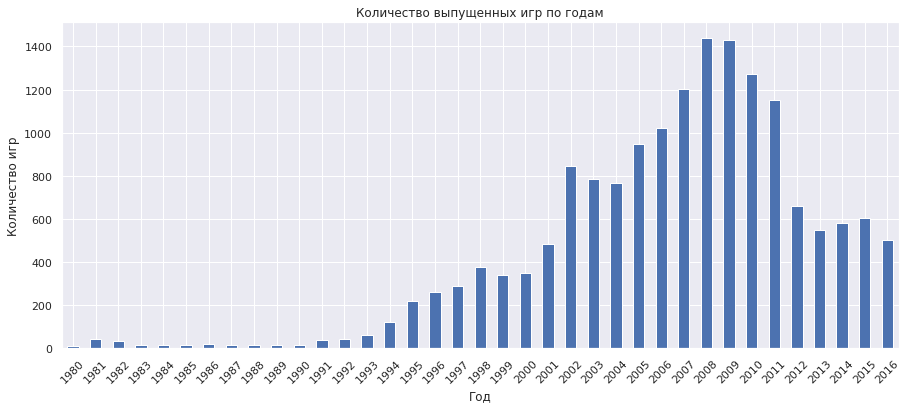

In [42]:
df.year_of_release.value_counts().sort_index().plot(kind='bar', figsize=(15, 6), rot=45,\
                        title='Количество выпущенных игр по годам',  xlabel='Год', ylabel='Количество игр')

print('Максимальное количество игр', df.year_of_release.value_counts().sort_index().max(), \
      'выпущено в', df.year_of_release.value_counts().sort_index().idxmax(), 'году')
print('Минимальное количество игр', df.year_of_release.value_counts().sort_index().min(), \
      'выпущено в', df.year_of_release.value_counts().sort_index().idxmin(), 'году')

В период с 1980 по 1990 выпуск игр был относительно равномерным(есть незначительный рост в 1981 и 1982 году). С 1991 года можем отметить тренд к ежегодному увеличению количества выпущенных игр. Наблюдается пик в 1998 году. И наиболее продуктивным по выпуску игр был период с 2002 по 2011 год, с пиками 2008-209 годов. Можем отметить резкое снижение в 2012 году относительно 2011. Падение продолжилось и в 2013 году, а с 2014 года начинается незначительный рост. С учетом того, что данные за 2016 год могут быть не полными, мы не можем однозначно утверждать о наличии падения в 2016 году, относительно 2015.

Теперь посмотрим на объемы продаж в разные годы:

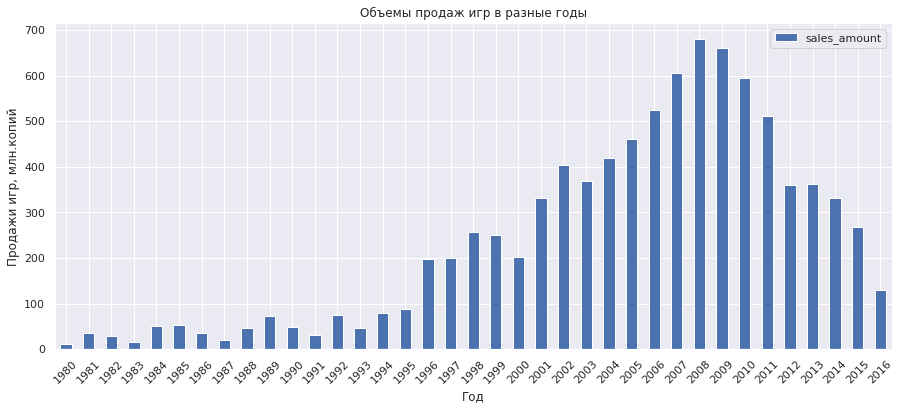

In [43]:
df.pivot_table(index='year_of_release', values='sales_amount', aggfunc='sum').sort_values(
    by='year_of_release').plot(kind='bar', figsize=(15, 6), rot=45, title='Объемы продаж игр в разные годы', \
                             xlabel='Год', ylabel='Продажи игр, млн.копий')
plt.show()

График продаж похож на график выпуска игр по годам. Наиболее продуктивный период продаж был также 2002-2011 годы. Пик продаж приходится на 2008-2009 годы. С 2010 года начинается постепенное снижение продаж.   
Еще выделяется несколько пиков 1981 год, 1984-1985, 1989, 1992 - в эти периоды объемы выпускаемых игр практически не менялись. Следующий всплеск продаж приходится на 1998-1989 годы, в эти же годы наблюдаем рост объемов выпускаемых игр. с 2013 года видим снижение объемов продаж.
Можно сказать, что объемы продаж связаны с увеличением разнообразия игровых предложений. 

### 3.2. Продажи игр по платформам

#### 3.2.1. Продажи игр по представленным платформам

Построим график распределения игр, реализованных на разных платформах:

Максимальное количество игр 2140 выпущенных для платформы PS2
Минимальное количество игр 1 выпущенных для платформы GG


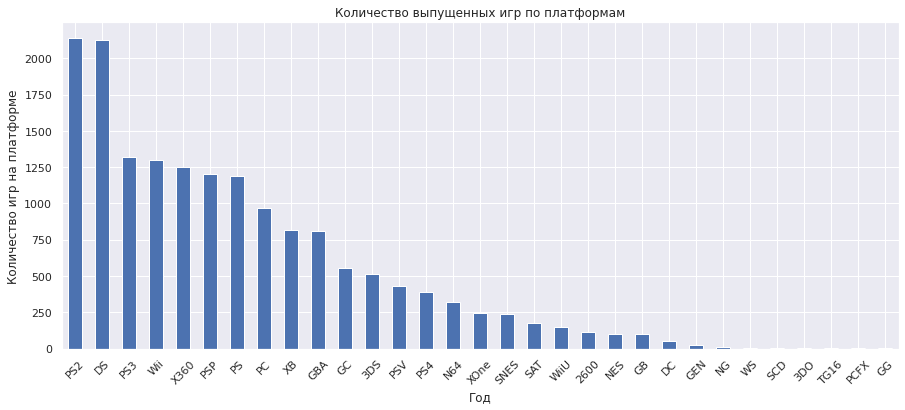

In [44]:
df.platform.value_counts().plot(kind='bar', figsize=(15, 6), rot=45,\
                           title='Количество выпущенных игр по платформам', \
                           xlabel='Год', ylabel='Количество игр на платформе')
print('Максимальное количество игр', df.platform.value_counts().sort_index().max(), \
      'выпущенных для платформы', df.platform.value_counts().sort_index().idxmax())
print('Минимальное количество игр', df.platform.value_counts().sort_index().min(), \
      'выпущенных для платформы', df.platform.value_counts().sort_index().idxmin())

Есть 2 явных лидера среди платформ по количеству выпущенных игр, это PS2 и DS - более 2000. Выделяется следующая группа игр с количеством выпуска более 1000: PS3, Wii, X360, PSP, PS. Для остальных платформ выпущено менее 1000 игр.

Теперь посмотрим на **объемы продаж по платформам**.

Описательная статистика продаж по платформам: 
        sales_amount
count     31.000000
mean     286.115484
std      346.504606
min        0.030000
25%       22.150000
50%      200.040000
75%      303.650000
max     1247.160000


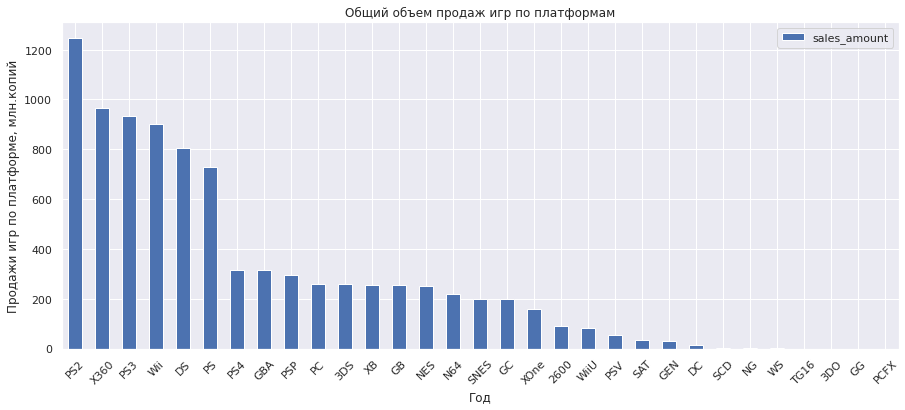

In [45]:
df.pivot_table(index='platform', values='sales_amount', aggfunc='sum').sort_values(
    by='sales_amount', ascending=False).plot(kind='bar', figsize=(15, 6), \
                                             title='Общий объем продаж игр по платформам', rot=45,
                                            xlabel='Год', ylabel='Продажи игр по платформе, млн.копий')
print('Описательная статистика продаж по платформам: \n', \
      df.pivot_table(index='platform', values='sales_amount', aggfunc='sum').describe())

Есть 1 явный лидер среди платформ по продажам игр - это **PS2** - 1247,16 млн копий. Эта платформа лидирует и по количеству выпущенных для нее игр и по объемам продаж. 
Выделяется следующая группа игр с количеством продаж более 600 млн копий: X360, PS3, Wii, DS, PS.
Посмотрим, как распределены суммарные продажи по всем платформам:

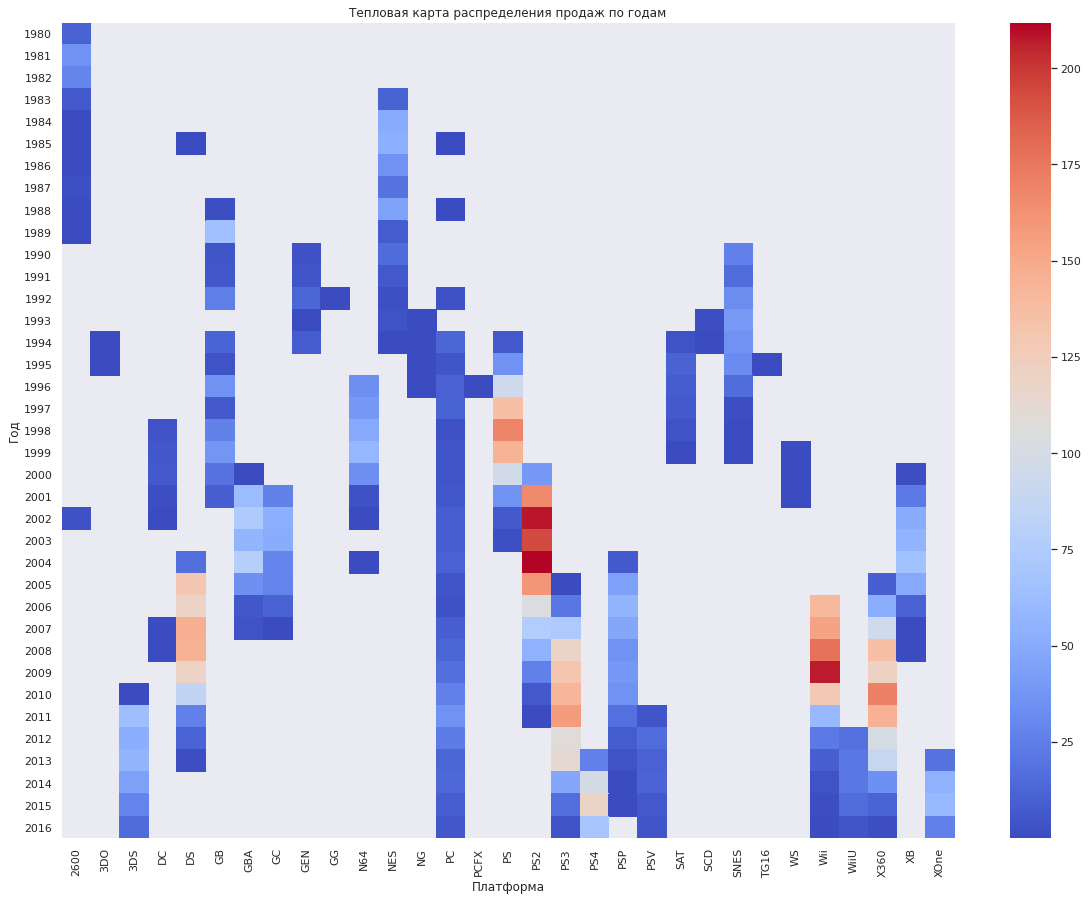

In [46]:
df_pl = df.pivot_table(index=['year_of_release'], columns='platform', values='sales_amount', aggfunc='sum')
fig, ax = plt.subplots(figsize=(20, 15))
ax.set(title='Тепловая карта распределения продаж по годам')
sns.heatmap(df_pl, cmap='coolwarm')
plt.xlabel("Платформа")
plt.ylabel("Год")
plt.show()

Получили тепловую карту, по которой, в зависимости от цвета и его насыщенности, видно объемы продаж по годам.
По тепловой карте видим, что платформы, в большинстве своем, имеют ограниченный срок существования. Дольше всех "живет" платформа **PC**.
Жизненный период большинства платформ можно описать нормальным распределением: каждая платформа начинает свою жизнь с минимальных продаж, далее в течение ряда лет наблюдается рост продаж, его пик и потом снова снижение, после чего многие платформы завершают свою жизнь.  Посмотрим детально на распределение продаж по годам на платформах-лидерах.   

#### 3.2.2. Распределение по годам для ТОП-3 платформ по объемам продаж

Топ-3 это платформы: 
- PS2
- X360
- PS3

Лидер по продажам - платформа PS2 - уже завершила свой "жизненный путь". Построим график распределения по годам и объемам выпуска игр  для ТОП-3 платформ.


Статистика по платформе: PS2 
        sales_amount
count     12.000000
mean     103.930000
std       80.496294
min        0.450000
25%       35.977500
50%       90.170000
75%      173.085000
max      211.810000

Статистика по платформе: X360 
        sales_amount
count     12.000000
mean      80.550833
std       57.716995
min        1.520000
25%       29.045000
50%       91.995000
75%      124.632500
max      170.550000

Статистика по платформе: PS3 
        sales_amount
count     12.000000
mean      77.932500
std       57.769741
min        0.190000
25%       20.285000
50%       90.735000
75%      121.825000
max      157.980000


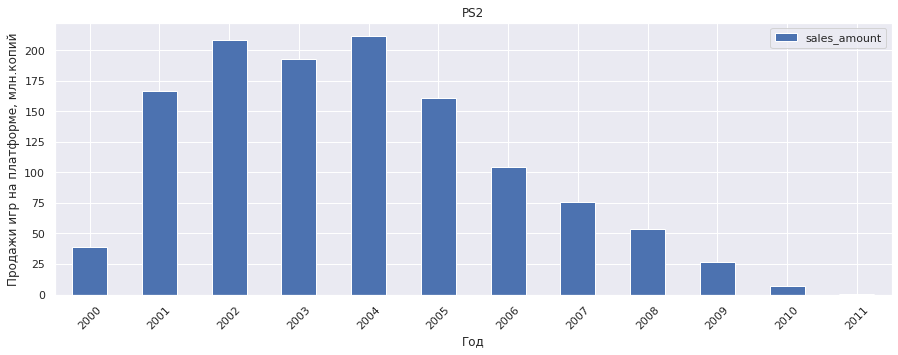

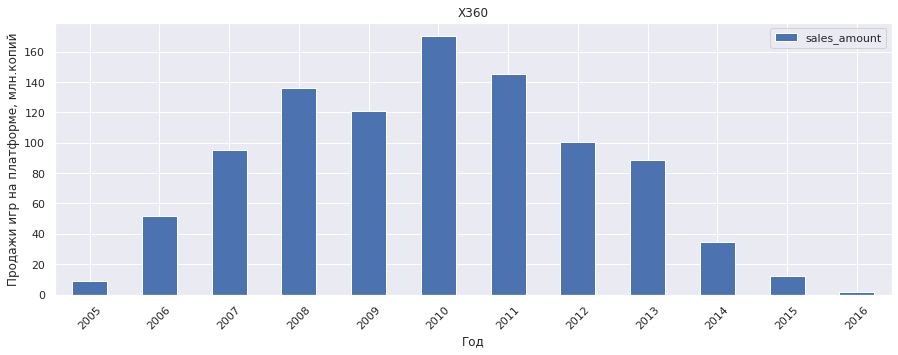

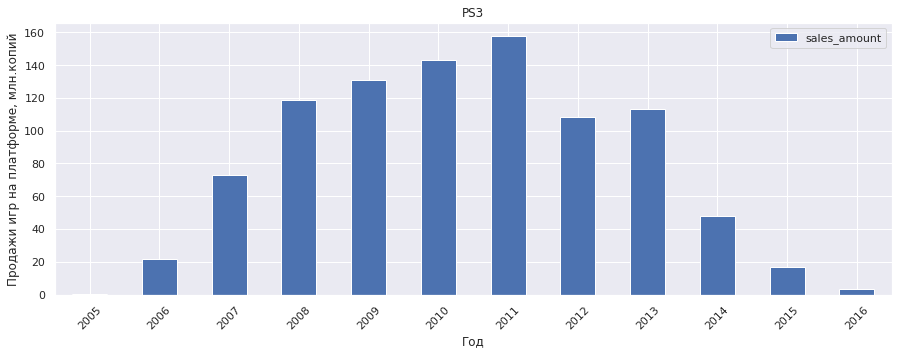

In [47]:
platform_top = ['PS2','X360', 'PS3']

for platform in platform_top:
    
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='sales_amount', aggfunc='sum')\
    .plot(kind='bar', figsize=(15,5), rot=45, xlabel='Год', ylabel='Продажи игр на платформе, млн.копий')
    plt.title(platform)
    print()
    print('Статистика по платформе:', platform, '\n', \
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='sales_amount', aggfunc='sum')\
          .describe())

**Платформа PS2**
Начало реализации в 2000 году, в 2001 году продажи существенно возросли - примерно в 6 раз. 2001-2005 годы были максимально продуктивными, в 2004 году было продано максимальное количество копий 211.81 млн. А с 2006 года отмечается равномерное снижение. Последняя реализация состоялась в 2011 году. 

**Платформа X360**
Начало реализации в 2005 году - примерно 8 млн, по 2008 год наблюдается  рост, а в 2009 году падение продаж (вероятно, покупатели переключились на вновь выпущенную игровую платформу). Однако в 2010 взлет продаж о своего максимума 170.55 млн копий. И с 2011 года видим тренд на снижение продаж до 2016 г. 

**Платформа PS3**
В 2005 году состоялись первые продажи - минимальное значение 0,19 млн. копий. Далее до 2011 года стабильный рост продаж, на 2011 год приходится их пик - 158 млн. копий и далее начинается снижение вплоть до 2016 года.

#### 3.2.3. Посчитаем средний срок "жизни" платформ.

По тепловой карте мы увидели, что большинство платформ существуют ограниченный период. Оценим этот период, для чего сгруппируем датафрейм по году и по платформе.

In [48]:
term = df[['year_of_release', 'platform']].drop_duplicates().groupby('platform').agg('count')

Описательная статистика срока жизни платформ: 
        year_of_release
count        31.000000
mean          7.806452
std           5.114811
min           1.000000
25%           4.000000
50%           7.000000
75%          11.000000
max          26.000000


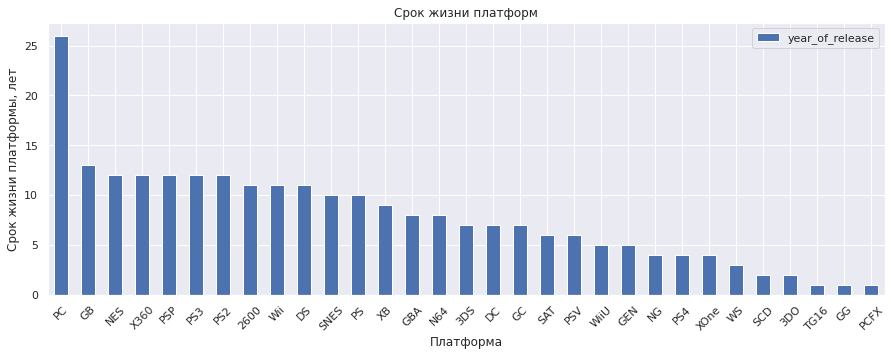

In [49]:
term.sort_values(by='year_of_release', ascending=False)\
          .plot(kind='bar', figsize=(15, 5), rot=45, title='Срок жизни платформ', \
          xlabel='Платформа', ylabel='Срок жизни платформы, лет')
print('Описательная статистика срока жизни платформ: \n', \
      term.describe())

Есть платформы со сроком жизни 1 год, максимальный срок жизни 26 лет, средний срок жизни платформ 7 лет.

Для сравнения оценим срок жизни у платформ с наиболее успешными объемами продаж, ТОП-10. Составим список этих платформ:

In [50]:
df.pivot_table(index='platform', values='sales_amount', aggfunc='sum').sort_values(
    by='sales_amount', ascending=False).head(10).index

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', 'PC'], dtype='object', name='platform')

In [51]:
term_top_10 = df.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', 'PC']")
term_top_10 = term_top_10[['year_of_release', 'platform']].drop_duplicates().groupby('platform').agg('count')

Описательная статистика срока жизни платформ: 
        year_of_release
count        10.000000
mean         11.800000
std           5.593647
min           4.000000
25%          10.250000
50%          11.500000
75%          12.000000
max          26.000000


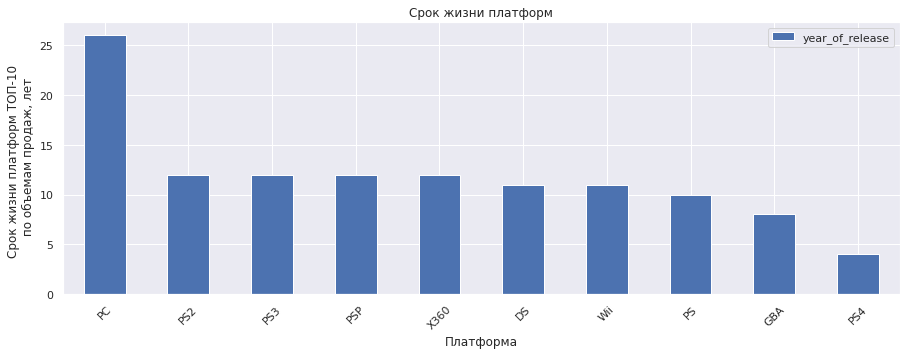

In [52]:
term_top_10.sort_values(by='year_of_release', ascending=False)\
          .plot(kind='bar', figsize=(15, 5), rot=45, title='Срок жизни платформ', \
          xlabel='Платформа', ylabel='Срок жизни платформ ТОП-10 \n по объемам продаж, лет')
print('Описательная статистика срока жизни платформ: \n', \
      term_top_10.describe())

Платформы с максимальными объемами продаж, в среднем, живут по 11-12 лет.

#### 3.2.4. Определим актуальный период для прогноза.

Для прогнозирования продаж на предстоящий период возьмем данные за последние 2 года - 2015-2016 годы. Отфильтруем исходный датафрейм и оставим только данные за этот период.

In [53]:
df_new = df.query("year_of_release >= 2015").reset_index(drop=True)
df_new.shape

(1108, 12)

In [54]:
print('В новом датафрейме', df_new.platform.nunique(), 'платформ.')
df_new.platform.unique()

В новом датафрейме 10 платформ.


array(['PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

У нас получился обновленный датафрейм из 1108 строк, в него вошли 10 платформ:  'PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', 'PSP'.

#### 3.2.5. Определим потенциальную прибыльность платформ

Построим для платформ актуального периода тепловую карту продаж и графики.

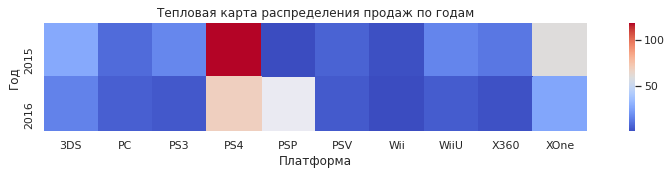

In [55]:
df_new_pl = df_new.pivot_table(index=['year_of_release'], columns='platform', values='sales_amount', aggfunc='sum')
fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(df_new_pl, square=True, cmap= 'coolwarm')
plt.title('Тепловая карта распределения продаж по годам')
plt.xlabel("Платформа")
plt.ylabel("Год")
plt.show()

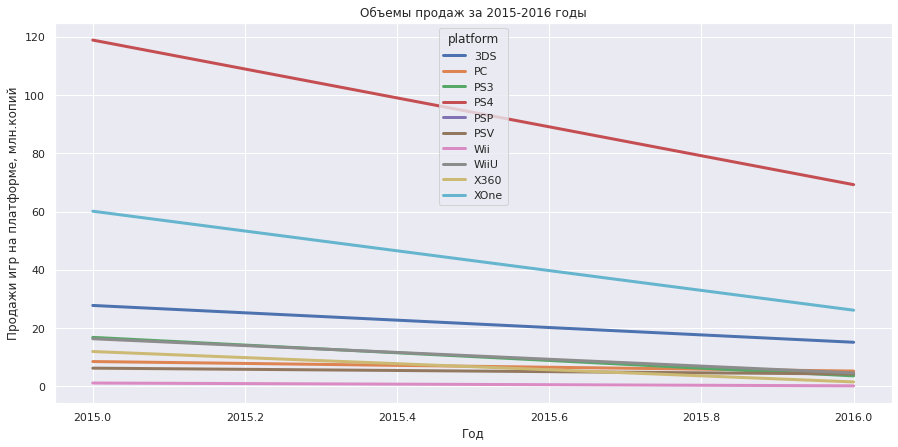

In [56]:
df_new_pl.plot(figsize=(15, 7), linewidth=3, title='Объемы продаж за 2015-2016 годы',\
              xlabel='Год', ylabel='Продажи игр на платформе, млн.копий')
plt.show()

По графику видим, часть платформ завершают свой жизненный путь - PS3, X360, Wii. Есть потенциал у платформ PS4, XOne, 3DS.   
Выделим распределение выручки по платформам.

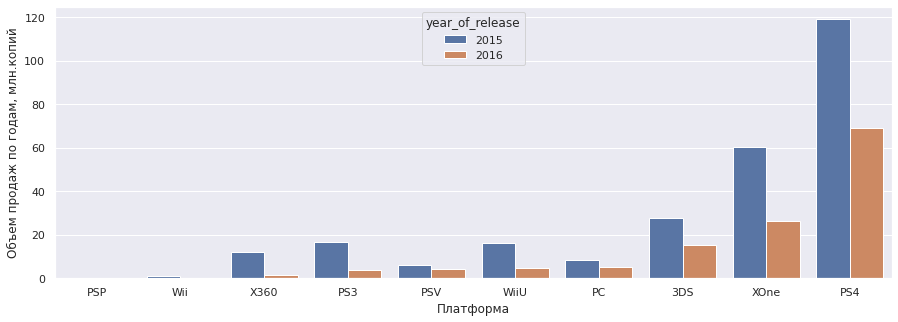

In [57]:
pl_lead = df_new.groupby(['platform', 'year_of_release'])['sales_amount']\
         .agg('sum').sort_values().reset_index()
plt.figure(figsize=(15,5))
sns.barplot(y='sales_amount', x='platform', hue='year_of_release', data = pl_lead)
plt.xlabel("Платформа")
plt.ylabel("Объем продаж по годам, млн.копий")
plt.show()

Получили график с объемами продаж в 2015 и 2016 годах. Данные отсортированы по возрастанию объемов продаж за 2016 год.

- У всех платформ наблюдается снижение суммарных продаж относительно предыдущего периода.
- По объемам продаж в 2016 год лидируют 3 платформы, PS4, XOne, 3DS и их потенциал не исчерпан.
- На платформах PC и PSV темпы снижения не столь резкие в сравнении с другими платформами. 
- Платформа PS4 появилась в 2013 году, срок жизни - 4 года, на предстоящий 2017 году, с учетом динамики объемов продаж, у нее самый лучший потенциал. Аналогично, платформа XOne, тоже появилась в 2013 году и на 2-м месте после PS4 по объемам продаж за предыдущий период. Платформа 3DS существует с 2010 года, срок жизни 7 лет. в 2016 году 3-я по объемам продаж.
- С учетом того, что платформа PC "живет" с 1985 года и имеет стабильно ежегодные продажи, ее можно считать потенциально прибыльной. Потенциально можно рассмотреть:
    - платформу PSV, существует с 2011 года, объемы продаж во все периоды стабильно не высокие, но без резких снижений, как, например, у платформы PS3, 
    - и относительно "молодую" платформу WiiU.

У нас получился список ТОП-6 потенциально прибыльных платформ на предстоящий период по объемам продаж и сроку жизни:
- **PS4**
- **XOne**
- **3DS**


- PC
- WiiU
- PSV

#### 3.2.6. Распределение продаж по платформам

Для 6 выбранных платформ PS4, XOne, 3DS, PC, PSV, WiiU создадим новый датафрейм, запишем его в переменную df_top

In [58]:
df_top = df_new.query("platform == ['PS4', '3DS', 'XOne', 'PC', 'PSV', 'WiiU']").reset_index(drop=True)
df_top.shape

(941, 12)

Построим для каждой платформы "ящик с усами", ограничим наш график по вертикали, для наглядности.

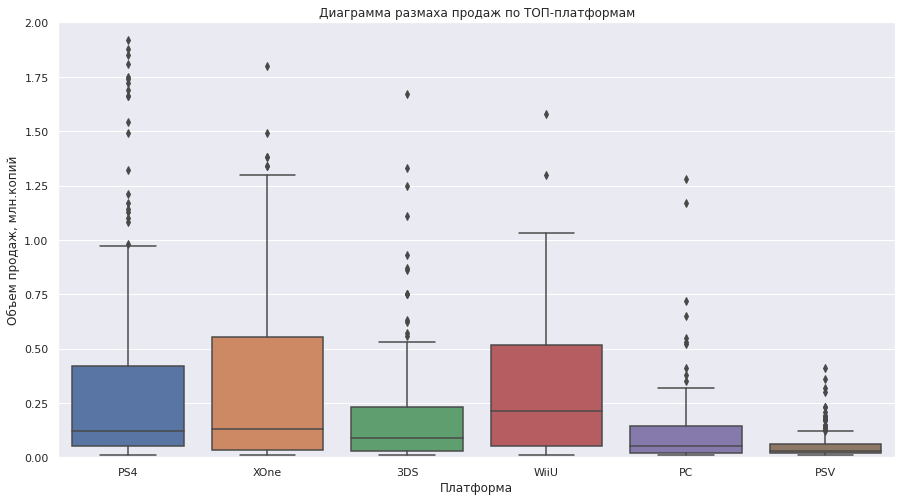

In [59]:
plt.figure(figsize=(15,8))
plt.ylim(0, 2)
plt.title('Диаграмма размаха продаж по ТОП-платформам')
sns.boxplot(x='platform', y='sales_amount', data=df_top)
plt.xlabel("Платформа")
plt.ylabel("Объем продаж, млн.копий")
plt.show()

Выведем описательную статистику продаж по каждой платформе.

In [60]:
df_top.groupby('platform')['sales_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,132.0,0.325152,0.798620,0.01,0.030,0.090,0.2325,7.14
PC,104.0,0.132404,0.209449,0.01,0.020,0.050,0.1425,1.28
PS4,301.0,0.625083,1.457063,0.01,0.050,0.120,0.4200,14.63
PSV,195.0,0.053846,0.063669,0.01,0.020,0.030,0.0600,0.41
WiiU,42.0,0.498810,0.850240,0.01,0.050,0.215,0.5175,4.44
XOne,167.0,0.516707,0.965940,0.01,0.035,0.130,0.5550,7.39


Медиана и среднее не совпадают ни у одной платформы, между ними значительная разница, что говорит о наличии выбросов, это мы видим по "ящикам с усами" и по максимальным значениям в описательной статистике, все ящики имеют верхние выбросы.   

Ящики показывают, что большинство игр по платформам продается в объемах "внутри ящика" - соответствующих межквартильному размаху, самый маленький межквартильный размах у платформы PSV. В каждой платформе есть игры, которые выдают нам выбросы по объемам продаж. Например, на платформе PS4 некоторые игры пользовались особой популярностью - продано более 14 млн копий. Можно посмотреть на эти игры:

In [61]:
df_top.query('sales_amount>14')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_amount
0,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,indefined,14.63


Для платформы *PS4* это игра *call of duty: black ops 3*.

#### 3.2.7. Влияние критиков и пользователей на продажи

На примере платформы PS4 оценим влияние оценок критиков и пользователей на продажи.

Матрица корреляции продаж и оценок критиков для платформы PS4


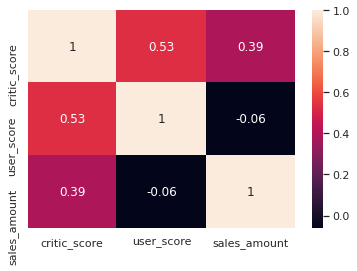

In [62]:
sns.heatmap(df_top.query('platform == "PS4"')[['platform', 'critic_score', 'user_score', 'sales_amount']]\
            .corr(), annot=True)
print('Матрица корреляции продаж и оценок критиков для платформы PS4')

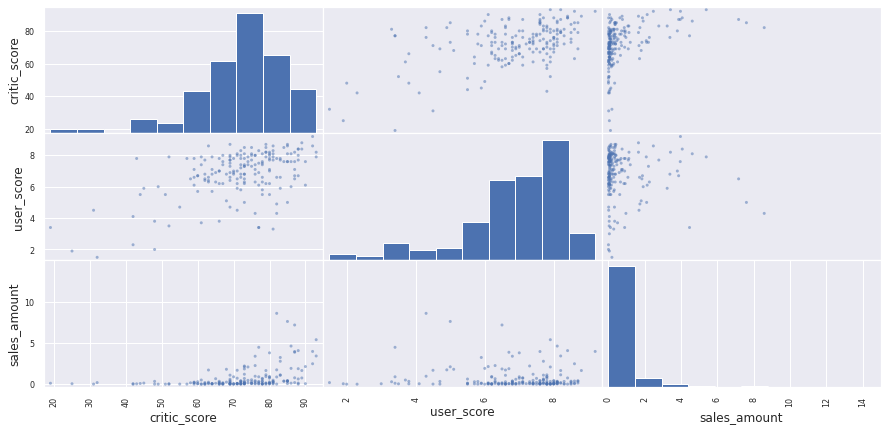

In [63]:
corr=df_top.query('platform == "PS4"')[['platform', 'critic_score', 'user_score', 'sales_amount']]
pd.plotting.scatter_matrix(corr, figsize=(15, 7)) 
plt.show()

Есть умеренное влияние оценок критиков на продажи (коэф. 0,39), а влияние оценок пользователей не выявлено (коэф. -0,06). Очевидно, на объемы продаж этой платформы влияют оценки критиков, но не влияют оценки пользователей.  
Построим диаграммы корреляций и посчитаем коэффициенты корреляций по всем 6 выбранным платформам.

In [64]:
def corr_score(name_plat):
    '''Функция для построения 
    диаграмм корреляций оценок и продаж
    по платформе,
    и для расчета коэффициента корреляций
    Args: название платформы        
    ''' 
    platform=df_top[df_top['platform']==name_plat]
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    sns.scatterplot(x='user_score', y='sales_amount', data=platform, ax=ax[0])   
    sns.scatterplot(x='critic_score', y='sales_amount', data=platform, ax=ax[1])
    
    fig.suptitle(name_plat)
    ax[0].set(xlabel="Оценки пользователей")
    ax[0].set(ylabel="Объем продаж, млн.копий")
    ax[1].set(xlabel="Оценки критиков")
    ax[1].set(ylabel="Объем продаж, млн.копий")
    
    plt.show()
    
    user_corr = platform['user_score'].corr(platform['sales_amount'])
    critic_corr = platform['critic_score'].corr(platform['sales_amount'])
    
    print('Коэффициент корреляции продаж с оценкой пользователей:', user_corr)
    print('Коэффициент корреляции продаж с оценкой критиков:', critic_corr)
    print('___________________________________________________________________________________')
    print()

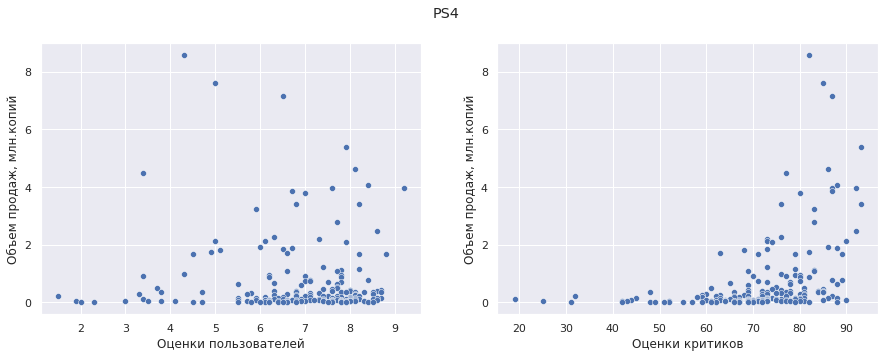

Коэффициент корреляции продаж с оценкой пользователей: -0.05973845712638215
Коэффициент корреляции продаж с оценкой критиков: 0.3928485555130601
___________________________________________________________________________________



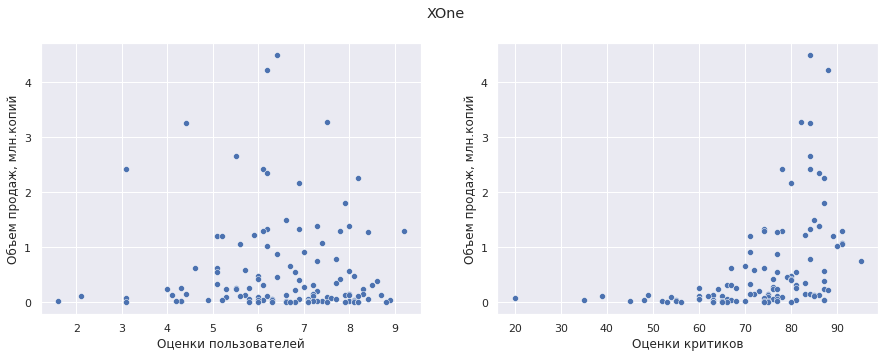

Коэффициент корреляции продаж с оценкой пользователей: -0.04146733387366271
Коэффициент корреляции продаж с оценкой критиков: 0.43088874582136805
___________________________________________________________________________________



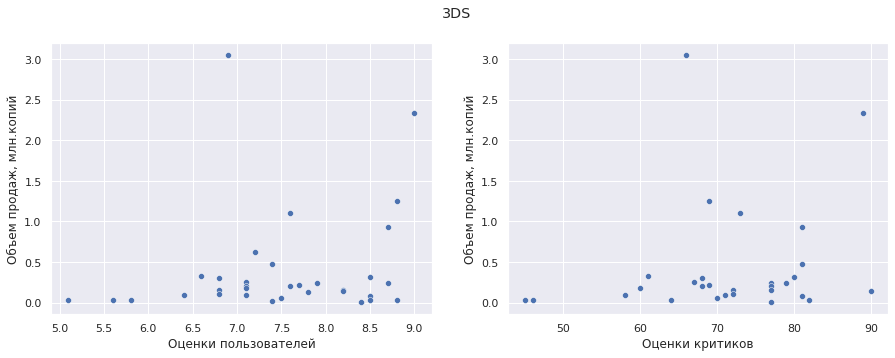

Коэффициент корреляции продаж с оценкой пользователей: 0.19879627008102982
Коэффициент корреляции продаж с оценкой критиков: 0.17757455046092874
___________________________________________________________________________________



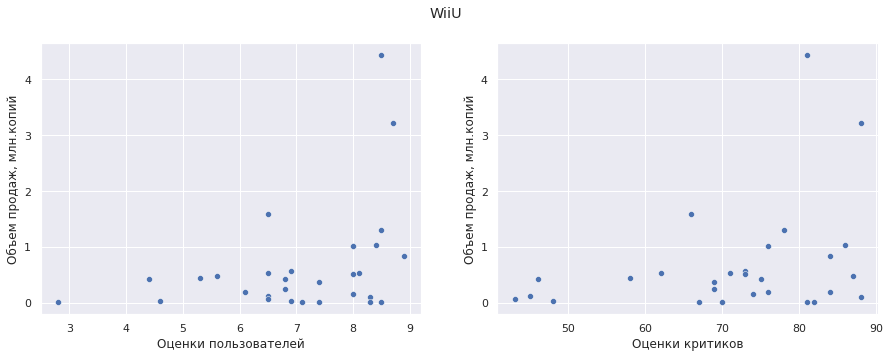

Коэффициент корреляции продаж с оценкой пользователей: 0.3635185724809445
Коэффициент корреляции продаж с оценкой критиков: 0.317045711769622
___________________________________________________________________________________



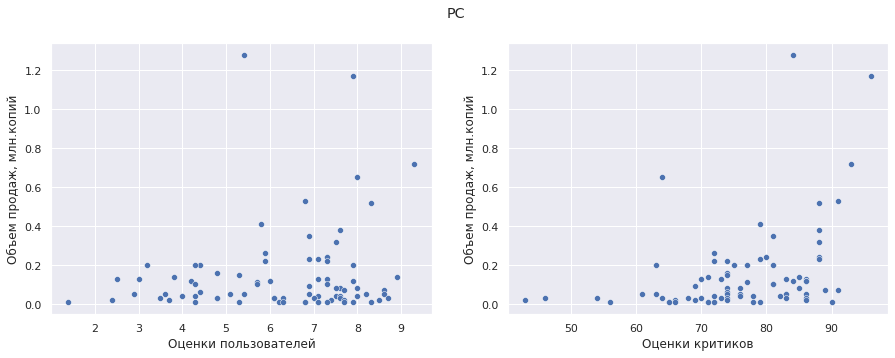

Коэффициент корреляции продаж с оценкой пользователей: 0.15038053045029076
Коэффициент корреляции продаж с оценкой критиков: 0.3773317477241351
___________________________________________________________________________________



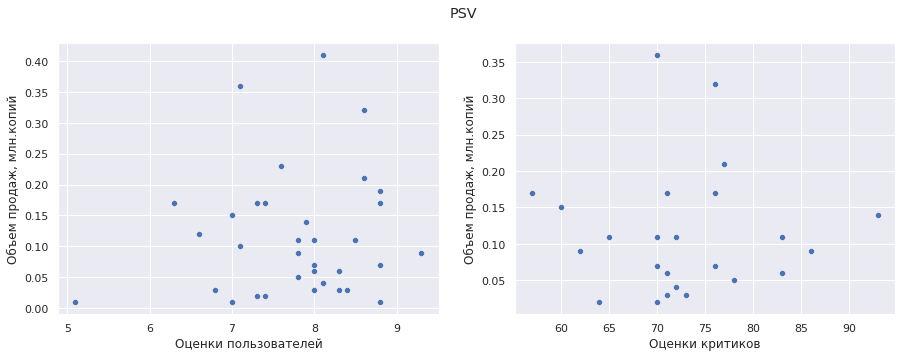

Коэффициент корреляции продаж с оценкой пользователей: 0.07833473556248864
Коэффициент корреляции продаж с оценкой критиков: 0.0036040833609397678
___________________________________________________________________________________



In [65]:
for platform in df_top['platform'].unique():
    corr_score(platform)

- Для платформ **PS4** и **XOne** выявлено влияние критиков на умеренном уровне 0,39 и 0,43, а влияние пользователей не выявлено (коэф. -0,6 и -0,4). 
- Продажи платформы **PC** в большей степени зависят от оценок критиков (коэф. 0,38) и слабо связаны с оценками пользователей (коэф. 0,15)
- Для платформы **3DS** коэф.критиков 0,18, коэф.пользователей 0,2. Влияние и критиков и пользователей прослеживается, но слабо.
- Для платформы **WiiU** картина влияния отличается от других платформ. Коэф. критиков 0,32, а коэф. пользоват. 0.36. Можем сказать, что на продажи этой платформы оказывают умеренное влияние и критики, и пользователи.   
- Между продажами и любыми оценками на платформе  **PSV** не прослеживается взаимосвязь - коэф.критиков 0,03, коэф. пользователей 0,08.    
  
В 5 случаях из 6 платформ выявлено влияние критиков на объемы продаж. И только в 3-х случаях влияние пользователей, из них в 2-х - слабый уровень влияния. Из чего можно сделать вывод, что критики в большей степени влияют на продажи, чем пользователи.

#### 3.2.8. Игровые жанры

Сформируем таблицу по игровым жанрам и на ее основе построим график распределения по количеству игр, представленных в определенном жанре и по объемам продаж по жанрам

df_top.pivot_table(index='genre', aggfunc = {'name': len, 'sales_amount': sum})\
.sort_values(by='sales_amount', ascending=False).reset_index()

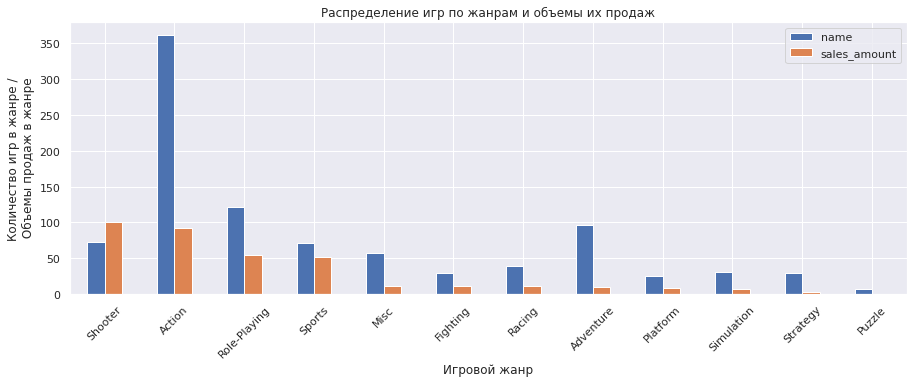

In [66]:
ax = df_top.pivot_table(index='genre', aggfunc = {'name': len, 'sales_amount': sum}).reset_index()\
.sort_values(by='sales_amount', ascending=False).plot(
    kind='bar',
    x='genre',
    figsize=(15, 5),
    rot=45,
    title='Распределение игр по жанрам и объемы их продаж',
    xlabel='Игровой жанр', 
    ylabel='Количество игр в жанре /\n Объемы продаж в жанре')

- На 1-м месте по продажам *Shooter*, при этом по количеству выпущенных игр он на 4-м месте.
- Больше всего игр создано в жанре *Action*, по объемам продаж он на 2-м месте.
- 3-е место по количеству выпущенных игр и по продажам занимает жанр *Role-Playing*

ТОП-5 жанров, которые продаются в наибольших объемах:
- Shooter
- Action
- Role-Playing
- Sports
- Misc

Меньше всего продаж в жанрах:
- Simulation
- Strategy
- Puzzle

Посмотрим на успешность продаж по жанрам, для этого сгруппируем таблицу по жанрам и средним продажам в конкретном жанре и на ее основе построим график:

In [67]:
df_top_pv = df_top.pivot_table(index='genre', values = 'sales_amount', aggfunc = ['count', 'sum', 'mean'])
df_top_pv.columns = ['count_sales', 'sum_sales', 'mean_sales']
df_top_pv.sort_values(by='mean_sales', ascending=False).head()

,count_sales,sum_sales,mean_sales
genre,,,
Shooter,73,100.87,1.381781
Sports,72,51.92,0.721111
Role-Playing,122,54.59,0.447459
Fighting,29,11.40,0.393103
Platform,25,8.98,0.359200


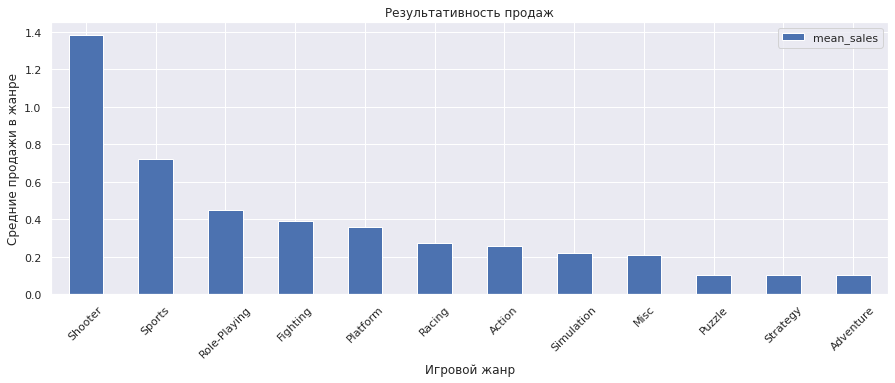

In [68]:
ax = df_top_pv.sort_values(by='mean_sales', ascending=False).plot(
    kind='bar',
    y='mean_sales',
    figsize=(15, 5),
    rot=45,
    title='Результативность продаж',
    xlabel='Игровой жанр', 
    ylabel='Средние продажи в жанре')

Пятерка жанров-лидеров с наиболее успешными продажами выглядит так:
- 'Shooter',
- 'Sports', 
- 'Role-Playing',
- 'Fighting', 
- 'Platform'

Наименее успешные жанры:  Puzzle, Strategy, Adventure
    


Жанр 'Action', который по объемам продаж занял у нас 2-е место, по успешности продаж находится на 7-м.
При этом в ТОП-5 успешных жанров вошли жанры 'Fighting' и 'Platform', которые по объемам продаж находятся на 6-м и 9- местах соответственно.

### 3.3. Выводы по 3-му этапу.

Мы проанализировали развитие  рынка игровой индустрии с 1985 по 2016 годы. Отметим следующие особенности:

1.	Игровая индустрия более активно развивалась с **1991 года - наметился рост количества предлагаемых игр.**  В 90-е годы пик активности пришелся на 1998 год. А **с 2002 года начался наиболее активный рост игрового разнообразия**, который достиг своего **максимума в 2008-2009 годах.** С **2010 года начался этап снижения** продуктивности в разработке новых игр. С этого периода начинают активно развиваться мобильные игровые приложения. В 2013 году количество выпущенных игр и объемы их продаж приблизились к уровню 2001 года. С 2014 отмечается незначительный рост. Распределение объемов продаж, в целом, повторяет распределение игр, представленных на рынке в этот отчетный период. Максимальный объем продаж пришелся на 2008-2009 годы.  Можно сказать, что **объемы продаж связаны с увеличением или уменьшением разнообразия игровых предложений.**    


2.	По объемам выпущенных и проданных копий **за весь период лидировала платформа PS2.** В 2011 году эта платформа прекратила свое существование. Помимо PS2, в тройку лидеров по объемам продаж вошли игровые платформы **X360 и PS3.**  Игры на этих платформах предлагаются по 2016 год включительно. 


3.	**Большинство платформ существует ограниченный период.** Есть платформы со сроком жизни 1 год, максимальный срок жизни 26 лет, **средний срок жизни платформ 7 лет.** Жизненный период большинства платформ можно описать нормальным распределением: каждая платформа начинает свою жизнь с минимальных продаж, далее в течение ряда лет наблюдается рост продаж, его пик и потом снова снижение, после чего многие платформы завершают свое существование. Долгожителем является платформа PC (26 лет). Средний срок жизни ТОП-10 платформ с максимальными объемами продаж за весь период, составляет 11-12 лет.


4. Определили **актуальный период** для дальнейших расчетов и прогнозов – 2015-2016 год*.   


5.	На основании анализа объемов продаж и тренда, выявили, что **у всех платформ присутствует тренд на снижение объемов продаж год к году.** Но **некоторые** из указанных платформ  еще **имеют потенциал для продаж в будущем периоде.** Составили список из **6 потенциально прибыльных платформ** в порядке убывания потенциала: 
- **PS4**
- **XOne**
- **3DS**
- PC
- WiiU
- PSV


6. Проверили наличие взаимосвязи объемов продаж с оценками критиков и оценками пользователей по выбранным 6 платформам. В  4 случаях из 6 платформ выявлено влияние критиков на объемы продаж (коэф. от 32 до 43%) . И только в 2-х случаях влияние пользователей (коэф. 22 % и 36%). Из чего можно сделать вывод, что критики в большей степени влияют на уровень продаж, чем пользователи.


7.  Определили **ТОП-5** наиболее успешных по продажам жанра: 

- 'Shooter',
- 'Sports',
- 'Role-Playing',
- 'Fighting',
- 'Platform'

Наименее успешные жанры:  Puzzle, Strategy, Adventure

## 4. Портреты геймеров по регионам

Продажи игр в данных представлены по 4-м регионам:
- `na_sales` — Северная Америка
- `eu_sales` — Европа
- `jp_sales` — Япония
- `other_sales` — другие страны

Посмотрим, есть ли отличия в предпочтениях геймеров из этих регионов по платформам, жанрам и как влияет возрастной рейтинг игр на их популярность. Есть смысл изучить эти предпочтения за последние периоды 2 года, что предпочитают пользователи в разных регионах. Поэтому, возьмем данные за 2015 и 2016 годы (с учетом того, что 2016 год может быть неполным, включим в анализ и 2015 год).

### 4.1. Продажи в регионах по популярным игровым платформам

Сформируем сводную таблицу, рассчитаем долевой вес каждой платформы по региону и выделим ТОП-5 платформ в каждом регионе.

ТОП-5 платформ по регионам

          eu_sales  shares
platform                  
PS4          83.54   56.47
XOne         28.10   18.99
PC            9.10    6.15
3DS           7.39    5.00
PS3           7.30    4.93

          jp_sales  shares
platform                  
3DS          23.55   44.10
PS4          12.05   22.57
PSV           8.41   15.75
PS3           4.97    9.31
WiiU          4.12    7.72

          na_sales  shares
platform                  
PS4          63.86   42.07
XOne         50.30   33.14
3DS          10.31    6.79
WiiU          8.86    5.84
X360          8.05    5.30

          other_sales  shares
platform                     
PS4             28.70   64.08
XOne             7.71   17.21
PS3              2.49    5.56
3DS              1.67    3.73
WiiU             1.48    3.30



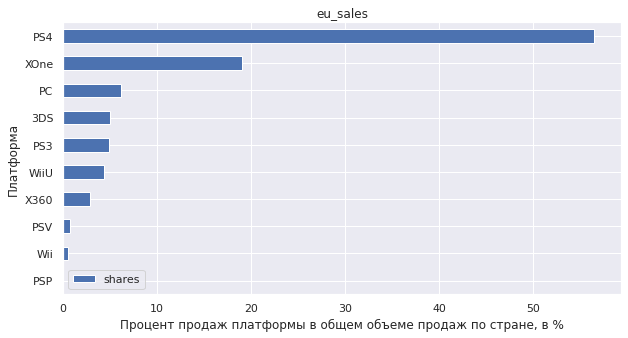

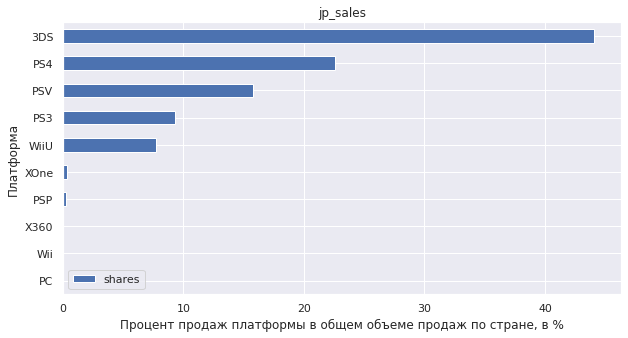

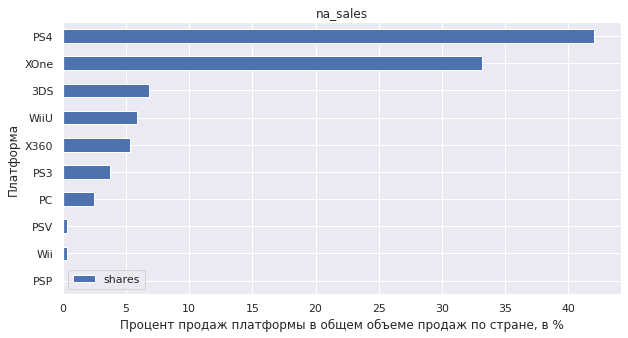

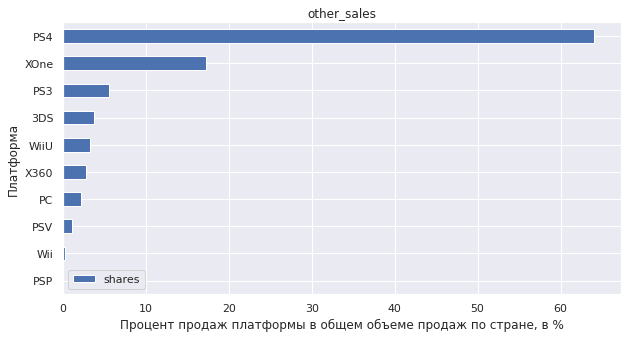

In [69]:
print('ТОП-5 платформ по регионам')
print()
region = ['eu_sales', 'jp_sales', 'na_sales', 'other_sales'] #создадим список регионов

for k in region:
    top_5_platform = df_new.pivot_table(index='platform', \
                    values=[k], aggfunc= 'sum').sort_values(by=k, ascending=False)
    top_5_platform['shares'] = round(top_5_platform[k] / top_5_platform[k].sum()*100, 2)
    
    top_5_platform.sort_values(by='shares').plot(kind='barh', y='shares', figsize=(10,5))\
                    .set(xlabel='Процент продаж платформы в общем объеме продаж по стране, в %', ylabel='Платформа')
    plt.title(k)
    print(top_5_platform.head())
    
    print()

- Во всех регионах, кроме Японии, лидирует платформа **PS4**, особенно она популярна в других странах. 
- На 2-м месте **XOne** везде, кроме Японии. 
- 3-е место занимают разные платформы. 
- Платформа **PC** входит в ТОП-3 в Европе, а в других странах не входит даже в ТОП-5, при этом,  в Европе не является популярной платформа **WiiU**, а в остальных регионах она входит в ТОП-5.  
- В Японии на 1-м месте платформа **3DS**, в других странах эта платформа присутствует в ТОП-5.  **PS4** в Японии занимает 2-е место. На 3-м месте в Японии платформа **PSV**, в других регионах она не входит в ТОП-5.

Общие платформы в ТОП-5 для всех регионов: **PS4, 3DS**. Игроки Японии по своим платформенным предпочтениям отличаются от игроков остальных регионов.

### 4.2. Продажи в регионах по популярным игровым жанрам

Теперь определим предпочитаемые жанры у игроков всех регионов. Сформируем сводную таблицу по жанрам.

Выделим ТОП-5 жанров в каждом регионе.

ТОП-5 жанров по регионам

              eu_sales  shares
genre                         
Shooter          40.28   27.23
Action           34.82   23.54
Sports           27.82   18.80
Role-Playing     17.21   11.63
Racing            6.52    4.41

              jp_sales  shares
genre                         
Action           23.05   43.16
Role-Playing     13.41   25.11
Shooter           3.79    7.10
Misc              3.19    5.97
Adventure         2.22    4.16

              na_sales  shares
genre                         
Shooter          48.18   31.74
Action           33.68   22.19
Sports           26.31   17.33
Role-Playing     19.82   13.06
Misc              5.58    3.68

              other_sales  shares
genre                            
Shooter             13.48   30.10
Action              10.58   23.62
Sports               8.55   19.09
Role-Playing         5.38   12.01
Fighting             1.57    3.51



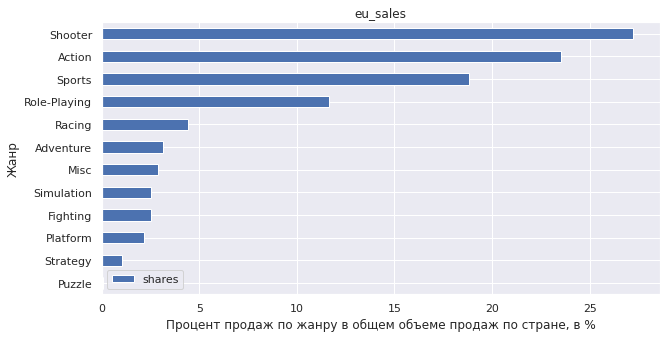

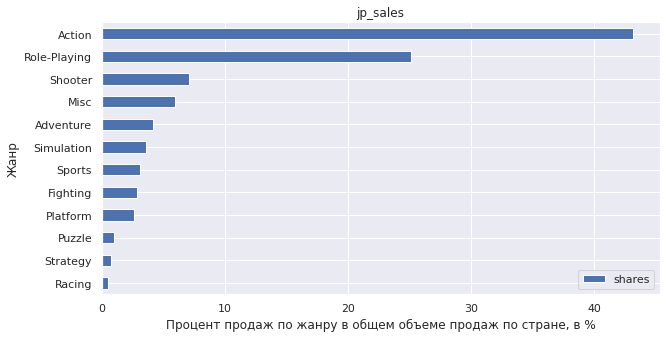

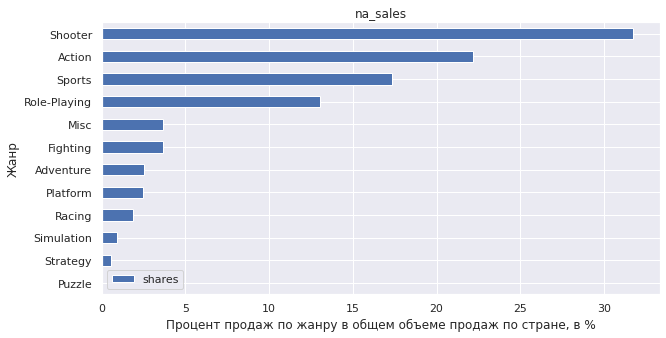

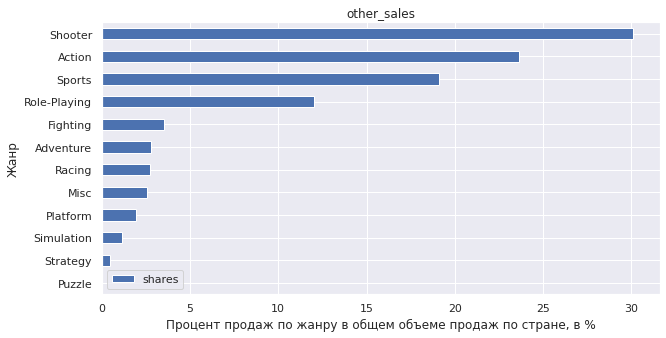

In [70]:
print('ТОП-5 жанров по регионам')
print()
for m in region:
    top_5_genre = df_new.pivot_table(index='genre', \
                    values=[m], aggfunc='sum').sort_values(by=m, ascending=False)
    top_5_genre['shares'] = round(top_5_genre[m] / top_5_genre[m].sum()*100, 2)
    top_5_genre.sort_values(by='shares').plot(kind='barh', y='shares', figsize=(10,5))\
                    .set(xlabel='Процент продаж по жанру в общем объеме продаж по стране, в %', ylabel='Жанр')
    plt.title(m)
    print(top_5_genre.head())
    print()

- На рынке Европы, Сев. Америки и других стран самый популярный жанр - **Shooter** - 1 место, а в Японии он только на 3-м месте. 
- В Японии 1-е место занимает жанр **Action**, в остальных регионах он на 2-м месте.
- В Европе, Сев. Америке и других странах на 3-м месте жанр **Sports**, в Японии он не входит в ТОП-5.
- В Европе, Сев. Америке и других странах на 4-м месте жанр **Role-Playing**, в Японии он занимает 2-е место.
- 5 место во всех регионах отличается. 

Из всего сказанного следует вывод, что игровые предпочтения в Японии существенно отличаются от остальных регионов. А в Европе, Сев. Америке и остальных странах игровые предпочтения, в основном, совпадают.

### 4.3. Продажи по возрастному рейтингу игр

Определим, как влияет возрастной рейтинг на продажи в разных регионах.    
Напомним описание возрастных рейтингов:

    EC - "Early childhood". Игра подходит для детей от 3 лет;
    E10+ - "Everyone 10 and older". Возрастная категория — от 10 лет;
    E - "Everyone". Для возрастной категории от 6 лет и старше;
    T - "Teen". Игра подходит для лиц от 13 лет и старше;
    M - "Mature". Игры не подходят для подростков младше 17 лет;
    AO - "Adults Only 18+". Содержание игры только для взрослых;
    RP - "Рейтинг ожидается". Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официального релиза
    K-A - Kids to Adults, устаревший рейтинг. «Для детей и взрослых». Подходит для возрастной категории от 6 лет и старше. Этот рейтинг был заменён на «Everyone» 1 января 1998 года и может встречаться только в играх, изданных ранее.


Сформируем сводную таблицу по рейтингам:

In [71]:
df_rating = df_new.query('year_of_release >= 2015').pivot_table(index='rating',\
                    values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
df_rating

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,34.90,5.25,26.59,8.57
E10+,12.19,3.27,18.32,4.14
M,48.01,4.50,49.06,15.02
T,20.82,7.78,23.31,7.01
indefined,32.02,32.60,34.51,10.05


На основе таблицы построим графики распределения:

Предпочтения по возрастным рейтингам в разных странах


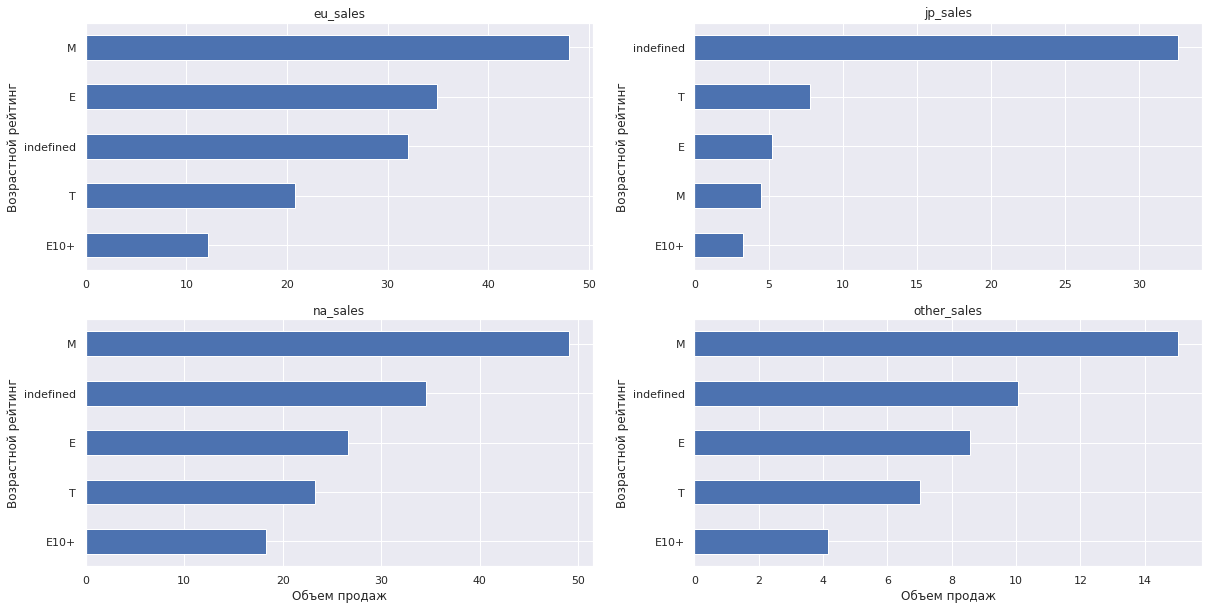

In [72]:
fig, axis = plt.subplots(2,2, figsize=(20,10))

df_rating['eu_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,0], title='eu_sales')\
                                                .set(ylabel='Возрастной рейтинг')
df_rating['jp_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,1], title='jp_sales')\
                                            .set(ylabel='Возрастной рейтинг')
df_rating['na_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,0], title='na_sales')\
                                                .set(ylabel='Возрастной рейтинг', xlabel='Объем продаж')
                                          
df_rating['other_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,1], title='other_sales')\
                                                   .set(ylabel='Возрастной рейтинг', xlabel='Объем продаж')

print('Предпочтения по возрастным рейтингам в разных странах')

У нас есть значительная часть игр с неопределенным рейтингом "indefined". Во всех регионах игры без категории ESRB входят в ТОП-3 покупок, в Японии - эта категория на 1-м месте. В данном случае, это может говорить об отсутствии у игры рейтинга 
ESRB, т.к. этот рейтинг составляется для Северной Америки. Но и в Северной Америке покупки игр без категории стоят на 2-м месте - либо у игры не определен рейтинг ESRB, либо при сборе информации он отсутствовал или "потерялся". 

Рейтинг ESRB в продажах представлен следующим образом:

- В Европе, Сев. Америке и других странах наибольшей популярностью пользуется возрастной рейтинг "М" - для взрослой аудитории - старше 17 лет. Следом идет рейтинг "Е" - от 6 лет, затем "Т" - от 13 лет, и меньше всего покупают рейтинг "Е10+" - от 10 лет во всех регионах.   
- В Японии чаще покупают категорию "Т", потом "Е", и затем "М". Т.е. лидируют игры для детей, игры для взрослой аудитории от 17 лет приобретают реже. 

### 4.4. Выводы.

Пользователи Европы предпочитают: 
- платформы: *PS4, XOne, PC, 3DS, PS3*
- жанры: *Shooter, Action, Sports, Role-Playing, Racing*
- возраст: *"М" - старше 17 лет,  "Е" - от 6 лет, "Т" - от 13 лет, реже  "Е10+" - от 10 лет*


Пользователи Японии предпочитают: 
- платформы: *3DS, PS4, PSV, PS3, WiiU* 
- жанры: *Action, Role-Playing, Shooter, Misc, Adventure*
- возраст: *"Т" - от 13 лет, "Е" - от 6 лет, "М" - старше 17 лет, реже  "Е10+" - от 10 лет*

Пользователи Сев.Америки предпочитают:
- платформы: *PS4, XOne, 3DS, WiiU, X360* 
- жанры: *Shooter, Action, Sports, Role-Playing, Misc*
- возраст: *"М" - старше 17 лет,  "Е" - от 6 лет, "Т" - от 13 лет, реже "Е10+" - от 10 лет*

Пользователи остальных стран предпочитают: 
- платформы: *PS4, XOne, PS3, 3DS, WiiU*
- жанры: *Shooter, Action, Sports, Role-Playing, Fighting*
- возраст: *"М" - старше 17 лет,  "Е" - от 6 лет, "Т" - от 13 лет, реже "Е10+" - от 10 лет*


Проанализировав игровые предпочтения во всех регионах, мы выявили:

1.	Игровые предпочтения в Японии отличаются от остальных стран как по «любимым» платформам, так и по «любимым» жанрам. А в Европе, Сев. Америке и остальных странах игровые предпочтения, в основном, совпадают. 

- ТОП-5 платформ в разных странах не одинаково. В  Европе, Сев. Америке и остальных странах совпадают 2 первые позиции  - наибольшей популярностью пользуются платформы **PS4 и XOne**, с 3-й позиции начинается разнообразие по предпочитаемым платформам в каждом из регионов. В Японии **любимая платформа 3DS**, а **PS4 на 2-м месте**.    
Общие платформы в ТОП-5 для всех регионов: **PS4, 3DS**.
- ТОП-5 жанров в Европе, Сев. Америке и остальных странах практически совпадает с 1 по 4-ю позиции: **Shooter, Action, Sports, Role-Playing**, 5-я позиция отличается.    
В Японии Любимые жанры: **Action, Role-Playing, Shooter** - они же 3 общих любимых жанра для всех регионов.


2.	Рейтинг ESRB в продажах представлен следующим образом:
- В Европе, Сев. Америке и других странах наибольшей популярностью пользуется возрастной рейтинг "М" - для взрослой аудитории - старше 17 лет. Следом идет рейтинг "Е" - от 6 лет, затем "Т" - от 13 лет, и меньше всего покупают рейтинг "Е10+" - от 10 лет во всех регионах.
- В Японии чаще покупают категорию "Т", потом "Е", и затем "М". Т.е. лидируют игры для детей, игры для взрослой аудитории от 17 лет приобретают реже.



## 5. Проверка гипотез

Теперь приступим к проверке наших гипотез:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports разные.

Для проверки используем датафрейм *df_new*, который у нас содержит данные 2010 года. 

### 5.1. Сравнение пользовательских рейтингов платформ *Xbox One* и *PC*

Проверим 1-ю гипотезу.

Нулевая гипотеза: `Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (равны)`.

Альтернативная гипотеза: `Средние пользовательские рейтинги платформ Xbox One и PC отличаются (не равны)`.
В качестве альтернативной используем двустороннюю гипотезу, т.к. нам требуется выяснить равенство в пользовательских оценках между платформами.
Для проверки гипотезы воспользуемся методом `scipy.stats.ttest_ind()`

Нам потребуются выборки пользовательских рейтингов по платформам  *XOne* и *PC*, запишем их в переменные *xone_score* и *pc_score*. Очистим их от пропусков.

In [73]:
xone_score = df_new[df_new['platform'] == 'XOne']['user_score'].dropna()
pc_score = df_new[df_new['platform'] == 'PC']['user_score'].dropna()

Посчитаем размер выборок

In [74]:
len(xone_score)

121

In [75]:
len(pc_score)

84

Поскольку размер одной выборки примерно в 1,5 раза больше другой, установим в расчете разные дисперсии в параметре - *equal_var*. Уровень статистической значимости *alpha* установим 0.01 для повышения точности.

In [76]:
alpha = 0.01
results = st.ttest_ind(xone_score, pc_score, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
print()
print('Средний пользовательский рейтинг платформы XOne', xone_score.mean())
print('Средний пользовательский рейтинг платформы PC', pc_score.mean())


p-значение: 0.2946308864003345
Нет оснований отвергнуть нулевую гипотезу

Средний пользовательский рейтинг платформы XOne 6.542148760330578
Средний пользовательский рейтинг платформы PC 6.29642857142857


Построим графики распределения оценок пользователей по двум платформам.

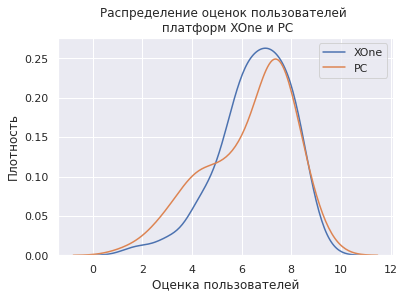

In [77]:
sns.kdeplot(xone_score, label='XOne')
sns.kdeplot(pc_score, label='PC')
plt.legend()
plt.title('Распределение оценок пользователей \n платформ XOne и PC')
plt.xlabel('Оценка пользователей')
plt.ylabel('Плотность')
plt.show()

На основе проведенного тестирования нет оснований отвергать нулевую гипотезу, мы не можем утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.

### 5.2. Сравнение пользовательских рейтингов жанров Action и Sports

Проверим 2-ю гипотезу.

Нулевая гипотеза: `Средние пользовательские рейтинги жанров Action и Sports равны.`

Альтернативная гипотеза: `Средние пользовательские рейтинги жанров Action и Sports разные (не равны).`

Наша альтернативная гипотеза двухсторонняя, т.к. у нас цель только подтвердить или опровергнуть наличие отличий. Для проверки гипотезы используем метод `scipy.stats.ttest_ind()`. 
Сформируем 2 выборки с рейтингами пользователей по игровым жанрам *Action* и *Sports*, запишем их в переменные *action_score* и *sports_score*, очистим от пропусков.

In [78]:
action_score = df_new[df_new['genre'] == 'Action']['user_score'].dropna()
sports_score = df_new[df_new['genre'] == 'Sports']['user_score'].dropna()

In [79]:
len(action_score)

193

In [80]:
len(sports_score)

82

Поскольку наши выборки для расчетов отличаются размерами более чем в 2 раза, установим в расчете разные дисперсии в параметре - *equal_var*. Уровень статистической значимости *alpha* установим 0.05.

In [81]:
alpha = 0.01
results = st.ttest_ind(action_score, sports_score, equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
print()
print('Средний пользовательский рейтинг жанра Action', action_score.mean())
print('Средний пользовательский рейтинг жанра Sports', sports_score.mean())


p-значение: 5.97163549920592e-10
Отвергаем нулевую гипотезу

Средний пользовательский рейтинг жанра Action 6.808290155440415
Средний пользовательский рейтинг жанра Sports 5.198780487804878


По значению p-value очевидно, что и при alpha 0,01 результат был бы таким же.
Постороим графики распределения оценок пользователей по двум жанрам.

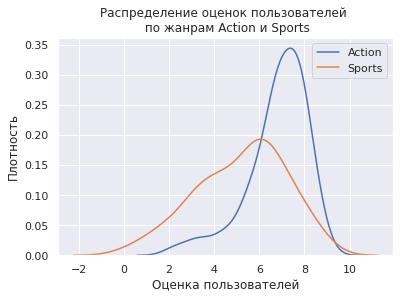

In [82]:
sns.kdeplot(action_score, label='Action')
sns.kdeplot(sports_score, label='Sports')
plt.legend()
plt.title('Распределение оценок пользователей \n по жанрам Action и Sports')
plt.xlabel('Оценка пользователей')
plt.ylabel('Плотность')
plt.show()

На основе проведенного тестирования по имеющимся данным у нас есть основание отвергнуть нулевую гипотезу о равенстве пользовательских рейтингов между жанрами Action и Sports . Есть основания утверждать наличие значимых различий между пользовательскими рейтингами.

### 5.3. Выводы.

По результатам тестирования имеющихся данных методом `scipy.stats.ttest_ind()`  выдвинутые гипотезы подтвердились:

1. У нас нет оснований отвергать гипотезу о равенстве пользовательских рейтингов по платформам  *XOne* и *PC*. Мы не можем утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.
2. На основе проведенного тестирования о равенстве пользовательских рейтингов между жанрами Action и Sports, у нас есть основания утверждать наличие значимых различий между пользовательскими рейтингами в этих жанрах.

## 6. Итоги исследования

1.	**Целью** исследования мы поставили себе задачу: 
Выявить закономерности, определяющие успешность игры, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в интернет-магазине «Стримчик» на следующий отчетный год.


2.	Для исследования использовали данные об игровом рынке из открытых источников.
В данных содержалась выборка об объемах продаж игр в мире, поделенном на 4 региона: Европа, Сев. Америка, Япония и другие страны. В данных указана принадлежность игр к платформам, жанру, оценки критиков и пользователей, а также возрастная классификация по ESRB. Данные потребовали проверки и некоторых корректировок:

- Заменили пропуски в столбцах, где было возможно и уместно: year_of_release, user_score , rating. В столбце *user_score* определили, что значение "tbd"  означает "To Be Determined", т.е. "Будет определено", это значит, оценка отсутствует.
- Удалили строки без названия игры и с пропуском года, где не смогли использовать замену.
- Актуализировали тип данных в столбцах year_of_release, user_score. 
- В данных отсутствуют дубликаты.
- Для дальнейших расчетов создали новый столбце с суммой продаж игры по всем регионам.
- В датафрейме представлены данные об играх с 1980 по 2016 годы:
    - за 37 лет.
    - 12 игровых жанров.
    - 31 игровая платформа. 
    - Минимальная оценка критика равна 13, максимальная - 90, середина всех оценок - 71 балл, большинство оценок критиков находятся между 60 и 80 баллами.
    - Минимальная оценка от пользователей равна 0,0, максимальная - 9,7, середина всех оценок 7,5. Пользователи чаще оценивают игры на уровне 6,3-8,1 баллов.
    

3. В процессе исследования данных выявили:
 - Игровая индустрия более активно развивалась с **1991 года**, активно создавались новые игры.  Максимальных значений, как по объемам продаж, так и по игровому разнообразию, игровой рынок достиг **в 2008-2009 годах.** С **2010 года начался этап снижения** его активности и продуктивности. Может быть обусловлено тем, что этого периода начинают активно развиваться мобильные игровые приложения. В 2013 году количество выпущенных игр и объемы их продаж приблизились к уровню 2001 года. 
- По объемам выпущенных и проданных копий **за весь период ТОП-3 платформ:**
    - PS2
    - X360
    - PS3
    
    
- **Большинство платформ существует ограниченный период.**  Средний срок жизни платформ из выборки **7 лет.** А средний срок жизни **самых успешных платформ по объемам продаж (ТОП-10) 11-12 лет**. Жизненный период для большинства платформ можно описать нормальным распределением: каждая платформа начинает свою жизнь с минимальных продаж, далее в течение ряда лет наблюдается рост продаж, его пик и потом снова снижение, после чего многие платформы завершают свое существование.
- Определили для дальнейшего анализа период с 2015-2016 год. На основании анализа объемов продаж  отметили тренд на их снижение год к году, при этом, выделили список платформ с потенциалом продаж на будущий период. 
    - PS4
    - XOne
    - 3DS
    - PC
    - WiiU
    - PSV
    

- Определили, что на объемы продаж в значительной степени влияют оценки критиков, а не пользователей.
- Определили **ТОП-5** наиболее успешных жанра: 
    - 'Shooter',
    - 'Sports',
    - 'Role-Playing',
    - 'Fighting',
    - 'Platform'
    
Наименее успешные жанры:  Puzzle, Strategy, Adventure


4.  Оценили  игровые предпочтения пользователей в зависимости от регионов продаж.
- Игровые предпочтения в Японии отличаются от остальных стран как по «любимым» платформам, так и по «любимым» жанрам. А в Европе, Сев. Америке и остальных странах игровые предпочтения, в основном, совпадают. 
    - В  Европе, Сев. Америке и остальных странах наибольшей популярностью пользуются платформы **PS4, XOne, 3DS**. В Японии **любимая платформа 3DS**, а **PS4 на 2-м месте**. Общие платформы в ТОП-5 для всех регионов: **PS4, 3DS**.
    - ТОП-5 жанров в Европе, Сев. Америке и остальных странах практически совпадает в ТОП-5: **Shooter, Action, Sports, Role-Playing**, 5-я позиция отличается.    
    - В Японии Любимые жанры: **Action, Role-Playing, Shooter, Misc**. 
    - **Action, Role-Playing, Shooter** - 3 общих любимых жанра для всех регионов.
- Рейтинг ESRB в продажах представлен следующим образом:
    - В Европе, Сев. Америке и других странах наибольшей популярностью пользуется возрастной рейтинг "М" - для взрослой аудитории - старше 17 лет. Следом идет рейтинг "Е" - от 6 лет, затем "Т" - от 13 лет, и меньше всего покупают рейтинг "Е10+" - от 10 лет во всех регионах.
    - В Японии чаще покупают категорию "Т", потом "Е", и затем "М". Т.е. лидируют игры для детей, игры для взрослой аудитории от 17 лет приобретают реже.
    

5. Резюмируя сказанное выше, расставим акценты:
- Платформы, с потенциалом продаж на будущий период:  *PS4, XOne, 3DS, PC, WiiU, PSV*;
- ТОП-5 наиболее доходных жанра: *Shooter, Sports, Role-Playing, Fighting, Platform*. Наименее доходные жанры: *Puzzle, Strategy, Adventure*;
- На объемы продаж в значительной степени влияют оценки критиков, а не пользователей;
- Самые популярные платформы в Европе, Сев. Америке и остальных странах: *PS4, XOne, 3DS*, в Японии *3DS, PS4, PSV*, общие любимые платформы для всех регионов *PS4, 3DS*
- Самые популярные общие жанры в Европе, Сев. Америке и остальных странах: *Shooter, Action, Sports, Role-Playing*, в Японии *Action, Role-Playing, Shooter, Misc*.
- Предпочтения по возрасту в Европе, Сев. Америке и остальных странах: *"М" - старше 17 лет,  "Е" - от 6 лет, "Т" - от 13 лет, реже рейтинг "Е10+" - от 10 лет*; в Японии - "Т" - от 13 лет, "Е" - от 6 лет, "М" - старше 17 лет, реже  "Е10+" - от 10 лет*